# Scenario modelling

## Set up environment

In [1]:
CM_BASEPATH = '../cibusmod'

import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), CM_BASEPATH))

In [2]:
import CIBUSmod as cm
import CIBUSmod.utils.plot as plot

import time
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import cvxpy

from typing import Literal

In [3]:
from CIBUSmod.utils.misc import inv_dict, aggregate_data_coords_pair
from CIBUSmod.optimisation.indexed_matrix import IndexedMatrix
from CIBUSmod.optimisation.utils import make_cvxpy_constraint
from itertools import product

In [4]:
# Create session
session = cm.Session(
    name = 'main',
    data_path = "data",
    data_path_default = CM_BASEPATH + "/data/default",
)

# Load scenarios
# ==============

session.add_scenario(
    "BASELINE",
    years=[2020],
    pars = "all",
    scenario_workbooks="default_fix"
)

session.add_scenario(
    "SCN_BASE",
    years=[2020],
    pars = "all",
    scenario_workbooks="base"
)

session.add_scenario(
    "SCN_MIN_LEY",
    years=[2020],
    pars = "all",
    scenario_workbooks=["base", "scn-min-ley"]
)

session.add_scenario(
    "SCN_REDUCED_MILK",
    years=[2020],
    pars = "all",
    scenario_workbooks=["base", "scn-milk"]
)

session.add_scenario(
    "SCN_SNG",
    years=[2020],
    pars = "all",
    scenario_workbooks="base"
)
   

In [5]:
%%time

scn = "SCN_BASE"

retrievers = {
    'Regions': cm.ParameterRetriever('Regions'),
    'DemandAndConversions': cm.ParameterRetriever('DemandAndConversions'),
    'CropProduction': cm.ParameterRetriever('CropProduction'),
    'FeedMgmt': cm.ParameterRetriever('FeedMgmt'),
    'GeoDistributor': cm.ParameterRetriever('GeoDistributor'),
}
    
cm.ParameterRetriever.update_all_parameter_values(**session[scn], year=2020)

# Instatiate Regions
regions = cm.Regions(
    par = retrievers['Regions'],
)

# Instantiate DemandAndConversions
demand = cm.DemandAndConversions(
    par = retrievers['DemandAndConversions'],
)

# Instantiate CropProduction
crops = cm.CropProduction(
    par = retrievers['CropProduction'],
    index = regions.data_attr.get('x0_crops').index
)

# Instantiate AnimalHerds
# Each AnimalHerd object is stored in an indexed pandas.Series
herds = cm.make_herds(regions)

# Instantiate feed management
feed_mgmt = cm.FeedMgmt(
    herds = herds,
    par = retrievers['FeedMgmt'],
)

# Instantiate geo distributor
optproblem = cm.FeedDistributor(
    regions = regions,
    demand = demand,
    crops = crops,
    herds = herds,
    feed_mgmt = feed_mgmt,
    par = retrievers['GeoDistributor'],
)

self = optproblem

# Add mgmt_modules:
WITH_MGMT_MODULES=True
if WITH_MGMT_MODULES:
    
    # Instantiate WasteAndCircularity
    waste = cm.WasteAndCircularity(
        demand = demand,
        crops = crops,
        herds = herds,
        par = cm.ParameterRetriever('WasteAndCircularity')
    )
    
    # Instantiate by-product management
    byprod_mgmt = cm.ByProductMgmt(
        demand = demand,
        herds = herds,
        par = cm.ParameterRetriever('ByProductMgmt')
    )
    
    # Instantiate manure management
    manure_mgmt = cm.ManureMgmt(
        herds = herds,
        feed_mgmt = feed_mgmt,
        par = cm.ParameterRetriever('ManureMgmt'),
        settings = {
            'NPK_excretion_from_balance' : True
        }
    )
    
    # Instantiate crop residue managment
    crop_residue_mgmt = cm.CropResidueMgmt(
        demand = demand,
        crops = crops,
        herds = herds,
        par = cm.ParameterRetriever('CropResidueMgmt')
    )
    
    # Instantiate plant nutrient management
    plant_nutrient_mgmt = cm.PlantNutrientMgmt(
        demand = demand,
        regions = regions,
        crops = crops,
        waste = waste,
        herds = herds,
        par = cm.ParameterRetriever('PlantNutrientMgmt')
    )
    
    # Instatiate machinery and energy management
    machinery_and_energy_mgmt  = cm.MachineryAndEnergyMgmt(
        regions = regions,
        crops = crops,
        waste = waste,
        herds = herds,
        par = cm.ParameterRetriever('MachineryAndEnergyMgmt')
    )
    
    # Instatiate inputs management
    inputs = cm.InputsMgmt(
        demand = demand,
        crops = crops,
        waste = waste,
        herds = herds,
        par = cm.ParameterRetriever('InputsMgmt')
    )

/root/cibus/scenarios/../cibusmod/CIBUSmod/utils/retriever.py:152: UserWarning: 
-----------------------------------------------------------------------------
Some filter values included in data were not available in relation_tables.xlsx.
Missing for 'feed': 'maize gluten meal', 'minerals', 'rapeseed cake'
Missing for 'by_prod': 'fish meal', 'maize gluten meal', 'soybean protein concentrate', 'cream', 'palm kernel expeller', 'luzern meal', 'soybean meal'
------------------------------------------------------------------------------
  warnings.warn(f"""


CPU times: user 21.4 s, sys: 153 ms, total: 21.6 s
Wall time: 21.9 s


In [6]:
cm.ParameterRetriever.update_all_parameter_values()
cm.ParameterRetriever.update_relation_tables()

cm.ParameterRetriever.update_all_parameter_values(**session[scn], year=2020)

regions.calculate()
demand.calculate()
crops.calculate()
for h in herds:
    h.calculate()

SCN_KWARGS = {}

cons=[1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 14]
if scn == "SCN_SNG":
    tol = 0.01
    self.make_x0()
    sng_areas = self.x0['crp'].loc[['Semi-natural pastures', 'Semi-natural pastures, thin soils', 'Semi-natural pastures, wooded']]
    SCN_KWARGS = {
        "C8_crp": sng_areas * (1 - tol),
        "C8_rel": '>='
    }
    cons.append(8)
    cons.sort()  

self.make(cons, verbose=True, **SCN_KWARGS)

/root/cibus/scenarios/../cibusmod/CIBUSmod/utils/retriever.py:152: UserWarning: 
-----------------------------------------------------------------------------
Some filter values included in data were not available in relation_tables.xlsx.
Missing for 'crop': 'Lentils'
Missing for 'animal': 'calves'
Missing for 'feed': 'maize gluten meal', 'minerals', 'rapeseed cake'
Missing for 'by_prod': 'fish meal', 'maize gluten meal', 'soybean protein concentrate', 'cream', 'palm kernel expeller', 'luzern meal', 'soybean meal'
------------------------------------------------------------------------------
  warnings.warn(f"""
/root/cibus/scenarios/../cibusmod/CIBUSmod/utils/retriever.py:164: UserWarning: 
--------------------------------------------------------------------------------------------
Data includes crop(s) without an x0 area specified through 'x0_crops' in the Regions module.
Missing: 'Wheat (add)', 'Peas (add)', 'Lentils'
-----------------------------------------------------------------

[ME, DM, PBV, fat, AAT, rough] [ME, DM, PBV, fat, AAT, rough] [ME, DM, PBV, fat, AAT, rough] [ME, DM, PBV, fat, AAT, rough] [ME, DM, PBV, fat, AAT, rough] [ME, DM, PBV, fat, AAT, rough] [ME] [ME] [ME] [ME] [ME] [ME] [ME] [ME] [NE] [NE] [DM] [DM] [DM] [DM] [DM] [DM] [DM] [DM] [DM] [DM] [DM] [DM] [17:20:26][FeedDistributor.make] Getting x0 and making indexes ... 11.7s
[17:20:37][FeedDistributor.make] Creating demand vector ... 0.0s
[17:20:37][FeedDistributor.make] Calculating scaling factors ... 0.1s
[17:20:37][FeedDistributor.make] Making objective O1 ... 0.4s
[17:20:38][FeedDistributor.make] Making constraint C1... 2.0s
[17:20:40][FeedDistributor.make] Making constraint C2... 0.8s
[17:20:41][FeedDistributor.make] Making constraint C3... 0.7s
[17:20:41][FeedDistributor.make] Making constraint C4... 0.6s
[17:20:42][FeedDistributor.make] Making constraint C5... 0.9s
[17:20:43][FeedDistributor.make] Making constraint C6... 1.4s
[17:20:44][FeedDistributor.make] Making constraint C10... 0.6s

## Data debugging

### Print size of matrices (latex table)

In [7]:
for (k, IM) in self.matrices().items():
    M = IM.M
    nrows, ncols = M.shape
    p = 100 * (M.nnz / (nrows*ncols))
    print(" & ".join(map(str, [
        k,
        nrows,
        ncols,
        M.nnz,
        f"{p:.3f}\\%\\\\"
    ])))

OBJ.P1 & 389444 & 388209 & 14665 & 0.000\%\\
C1.A1 & 84 & 388209 & 532749 & 1.634\%\\
C2.A2 & 1272 & 388209 & 72724 & 0.015\%\\
C3.A3 & 318 & 388209 & 35091 & 0.028\%\\
C4.A4 & 8 & 388209 & 23744 & 0.765\%\\
C5.A5 & 212 & 388209 & 12932 & 0.016\%\\
C6_max.A6 & 424 & 388209 & 46788 & 0.028\%\\
C10.A10 & 68 & 388209 & 143842 & 0.545\%\\
C11 (min).A11 & 373544 & 388209 & 4986240 & 0.003\%\\
C11 (eq).A11 & 373544 & 388209 & 5256328 & 0.004\%\\
C11 (max).A11 & 373544 & 388209 & 178080 & 0.000\%\\
C12 (min).A12 & 12720 & 388209 & 347680 & 0.007\%\\
C12 (eq).A12 & 15264 & 388209 & 390928 & 0.007\%\\
C12 (max).A12 & 12720 & 388209 & 360400 & 0.007\%\\
C14 (min).A14 & 373544 & 388209 & 4986240 & 0.003\%\\
C14 (max).A14 & 373544 & 388209 & 4986240 & 0.003\%\\


### Ensure feed_to_prod matches feeds

### List any crop/by products that are 100% imported

## Improve numerics

In [8]:
def improve_numerics(self):
    from CIBUSmod.optimisation.feed_dist import IndexedMatrix
   
    for name, C in self.constraints.items():
        M = [obj for obj in C['pars'].values() if isinstance(obj, IndexedMatrix)]
        assert len(M) == 1, "Expected one and only one IndexedMatrix"
        M = M[0]
        max_val = M.M.max()
        for name, obj in C['pars'].items():
            if isinstance(obj,IndexedMatrix):
                obj.M = obj.M / max_val
            else:
                obj[:] = obj / max_val

    print("Completed rescaling of matrices.")

improve_numerics(optproblem)

Completed rescaling of matrices.


In [9]:
# =========================================================================== #
# --------------- SOLVE, STORE, AND STOP IF ON BASELINE SCENARIO ------------ #
# =========================================================================== #

if scn == "BASELINE":
    self.solve(
        apply_solution=True,
        verbose=True,
        solver_settings=[{
            "solver": "GUROBI",
            "reoptimize": True,
            "verbose": True,
        }]
    )
    self.feed_mgmt.calculate()
    session.store(
        scn, 2020,
        demand, regions, crops, herds, optproblem
    )
    
    raise Exception("Stopping for BASELINE scenario")

# =========================================================================== #
# ---------------------------- OTHERWISE, CONTINUE -------------------------- #
# =========================================================================== #

# Replace the objective function

While the original optimisation objective focused on minimising the change, we now instead want to maximize the protein contents.

## Mapping `x` to protein contents

First we need to create a row-array that maps each element in `x` with its protein content, so that we compute the aggregate protein amount from the decision variable.

In [10]:
ADDED_PEAS = "Peas (add)"
ADDED_WHEAT = "Wheat (add)"

PROTEIN_CONTENTS = {
    ADDED_PEAS: 220,
    ADDED_WHEAT: 67.15,
    "meat": 155.5,
    "milk": 35.0,
}

# Convert to thousands of prot. / kg, instead of straight
for k in PROTEIN_CONTENTS.keys():
    PROTEIN_CONTENTS[k] /= 1e3

def make_protein_mask_ani():
    RELEVANT_ANIMAL_PRODUCTS = ["meat", "milk"]
    
    # Get row index from animal product demand vector (ps,sp,ap)
    row_idx = pd.MultiIndex.from_tuples(
        [
            ("conventional", "cattle", "meat"),
            ("conventional", "cattle", "milk"),
            ("organic", "cattle", "meat"),
            ("organic", "cattle", "milk"),
        ],
        names=["prod_system", "species", "animal_prod"]
    )

    # Get col index from animal herds (sp,br,ss,ps,re)
    col_idx = self.x_idx_short["ani"]

    # To store data and corresponding row/col numbers for constructing matrix
    val = []
    row_nr = []
    col_nr = []

    # Go through animal herds
    for herd in self.herds:
        sp = herd.species
        br = herd.breed
        ps = herd.prod_system
        ss = herd.sub_system

        if sp != "cattle":
            continue

        def get_uniq(col):
            return herd.data_attr.get("production").columns.unique(col)
        
        # Get all animal products that we are concerned with
        aps = set(get_uniq("animal_prod")) & set(RELEVANT_ANIMAL_PRODUCTS)
        opss = get_uniq("prod_system")
        
        for ap, ops in product(aps, opss):
            if (ops, sp, ap) not in row_idx:
                continue
        
            # Get production of animal product (ap) from output production system (ops) per head
            # of defining animal of species (sp) and breed (br) in production system (ps), sub system (ss)
            # and region (re)
            res = (
                herd.data_attr.get("production")
                .loc[:, (ops, slice(None), ap)]
                .sum(axis=1)
            ) * PROTEIN_CONTENTS[ap]
        
            if all(res == 0):
                continue
        
            val.extend(res)
            col_nr.extend([col_idx.get_loc((sp, br, ps, ss, re)) for re in res.index])
            row_nr.extend(np.zeros(len(res)))

    # Aggregate data_coords_pair to ensure that any overlapping values are summed rather than replace each other
    val, (row_nr, col_nr) = aggregate_data_coords_pair(val, row_nr, col_nr)

    # Create Compressed Sparse Column matrix
    return scipy.sparse.coo_array((val, (row_nr, col_nr)), shape=(1, len(col_idx))).tocsc()

def make_protein_mask_crp():
    val_df = (
        crops.data_attr.get('harvest').loc[['Wheat (add)']].reindex(self.x_idx_short["crp"]).fillna(0) * [PROTEIN_CONTENTS[ADDED_WHEAT]]
        + crops.data_attr.get('harvest').loc[['Peas (add)']].reindex(self.x_idx_short["crp"]).fillna(0) * [PROTEIN_CONTENTS[ADDED_PEAS]]
    )
    
    return scipy.sparse.csc_array(np.atleast_2d(val_df.values))

def make_protein_mask():
    A_ani = make_protein_mask_ani()
    A_crp = make_protein_mask_crp()
    A_fds = scipy.sparse.csc_matrix((1, len(self.x_idx_short["fds"])))

    return scipy.sparse.hstack([A_ani, A_crp, A_fds], format="csc")

make_protein_mask()

<Compressed Sparse Column sparse array of dtype 'float64'
	with 825 stored elements and shape (1, 388209)>

### Quick validity check

Ensure we only have values in the protein map where we expect to, i.e. for the added crops and for cattle.

In [11]:
if scn != "BASELINE":
    df_ani = pd.DataFrame(make_protein_mask_ani(), columns=self.x_idx_short["ani"])
    df_crp = pd.DataFrame(make_protein_mask_crp(), columns=self.x_idx_short["crp"])
    
    # Check that only the added crops have values in the crp part of the mask
    ADDED_CROPS = [ADDED_PEAS, ADDED_WHEAT]
    
    for crop in df_crp.columns.unique("crop"):
        is_all_zeroes = (df_crp.loc[:,(crop, slice(None), slice(None))]==0).all().all()
        assert is_all_zeroes == (crop not in ADDED_CROPS)
    
    # Check that only cattle has values in the ani part of the protein mask
    for sp in df_ani.columns.unique("species"):
        is_all_zeroes = (df_ani.loc[:,(sp, slice(None), slice(None), slice(None), slice(None))]==0).all().all()
        is_cattle = sp == "cattle"
        assert is_all_zeroes != is_cattle

## Construct and replace the `cvxpy.Problem`

In [12]:
prot_mask = make_protein_mask()

def protein_mask_as_opt_goal():
    n = (
        len(self.x_idx_short["ani"])
        + len(self.x_idx_short["crp"])
        + len(self.x_idx_short["fds"])
    )
    x = cvxpy.Variable(n, nonneg=True)

    M = prot_mask
    objective = cvxpy.Maximize(cvxpy.sum(M @ x))

    # Append constraints
    constraints = [
        make_cvxpy_constraint(cons, x) for cons in self.constraints.values()
    ]

    # Define problem
    self.problem = cvxpy.Problem(
        objective=objective,
        constraints=constraints
    )

# Prepare some plot-functions

In [13]:
def mkdirp(filepath: str):
    dirpath = os.path.dirname(filepath)
    if not os.path.exists(dirpath):
        os.mkdir(dirpath)

In [14]:
from matplotlib.colors import TwoSlopeNorm
from matplotlib.ticker import PercentFormatter

def plot_cattle_x0_x_chloropleths(figname: str | None = None):
    x0_cattle = self.x0["ani"].loc[("cattle",)]
    x_cattle = self.x["ani"].loc[("cattle",)].droplevel("sub_system").groupby(["breed", "prod_system", "region"]).sum()
    
    x0_cattle = x0_cattle.unstack("region")
    x_cattle = x_cattle.unstack("region")
    
    assert (x0_cattle.index == x_cattle.index).all(), "Expected index of x0 and x to match"
    
    N = len(x0_cattle.index.values)
    fig, axes = plt.subplots(N, 4, figsize=(20, N * 6))
    
    for pos, axs in zip(x0_cattle.index, axes):
        (ax_l, ax_r, ax_x, ax_x0) = axs
        
        x = x_cattle.loc[pos,:]
        x0 = x0_cattle.loc[pos,:]
    
        # Relative change
        # ---------------
        
        ## Plot 1: Chloropleth (relative)
        x_frac = x / x0
        ### create a normalized colorscheme, with 1=100% in the centre
        vmin, vcenter, vmax, = 0, 1, max(2, x_frac.max())
        norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
        ax_l.set_axis_off()
        ax_l.set_title(f"{pos[0]}, {pos[1]}")
        cm.plot.map_from_series(x_frac, ax=ax_l, cmap="RdBu", norm=norm)
        # Set the cbar formatter to percentage 
        ax_l.figure.axes[-1].yaxis.set_major_formatter(PercentFormatter(1))
            
        if any(x_frac > 0):
            ## Plot 2: KDE
            x_frac.plot(kind="kde", ax=ax_r)
            ax_r.xaxis.set_major_formatter(PercentFormatter(1))
            ax_r.set_xlim([0, vmax])
            ax_r.set_title("Distribution of change")
    
        # Absolute values: x and x0
        # -------------------------
        ax_x.set_axis_off()
        ax_x0.set_axis_off()
        x_vmax = max(x.max(), x0.max())
        x_vmin = max(x.min(), x0.min())
        ax_x.set_title("x: New values")
        ax_x0.set_title("x0: Original values")
        cm.plot.map_from_series(x, ax=ax_x, vmin=x_vmin, vmax=x_vmax)
        cm.plot.map_from_series(x0, ax=ax_x0, vmin=x_vmin, vmax=x_vmax)
    
    fig.tight_layout()
    if figname:
        mkdirp(figname)
        fig.savefig(figname)

In [15]:
def plot_crop_x0_x_chloropleths(figname: None | str = None): 
    def get_x(crp: str):
        return self.x["crp"].xs(crp, level="crop", drop_level=False).droplevel("prod_system")
    
    added_peas = get_x("Peas (add)")
    added_wheat = get_x("Wheat (add)")
    crops = [added_peas, added_wheat]
    
    print("added_peas", added_peas)
    print("added_wheat", added_wheat)
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 7))
    
    for data, ax in zip(crops, axes):
        title = data.index.unique("crop")[0]
        data = data.droplevel("crop")
        ax.set_title(title)
        ax.set_axis_off()
        cm.plot.map_from_series(data, ax=ax)
    
    if figname:
        mkdirp(figname)
        fig.savefig(figname)

# First run: Optimize for protein

In [16]:
%%time
protein_mask_as_opt_goal()
self.solve(
    apply_solution=False,
    verbose=True,
    solver_settings=[{
        "solver": "GUROBI",
        "reoptimize": True,
        "verbose": True,

        #"GURO_PAR_DUMP": 1,

        # Custom params
        "BarConvTol": 1e-8,
        # Sometimes setting Aggregate=0 can improve the model numerics
        # "Aggregate": 0,
        
        "NumericFocus": 3,
        # Useful for recognizing infeasibility or unboundedness, but a bit slower than the default algorithm.
        # values: -1 auto, 0 off, 1 force on.
        "BarHomogeneous": 1, 

        # Gurobi has three different heuristic algorithms to find scaling factors. Higher values for the ScaleFlag uses more aggressive heuristics to improve the constraint matrix numerics for the scaled model.
        "ScaleFlag": 2,

        # All constraints must be satisfied to a tolerance of FeasibilityTol.
        # default 1e-6
        "FeasibilityTol": 1e-3,
    }]
)

[17:23:00][FeedDistributor.solve] Finding solution with 'GUROBI' ... ===============================================================================
                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Jan 12 05:23:00 PM: Your problem has 388209 variables, 1910810 constraints, and 0 parameters.
(CVXPY) Jan 12 05:23:00 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 12 05:23:00 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 12 05:23:00 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 12 05:23:00 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                            

added_peas crop        region
Peas (add)  1011      4299.123078
            111       5111.820655
            1111      3130.032727
            1112      1521.003599
            112       3617.698650
                         ...     
            821       5214.256513
            831       2724.763502
            911       3191.376183
            912       7838.619761
            913       2799.808150
Length: 106, dtype: float64
added_wheat crop         region
Wheat (add)  1011      21487.082054
             111       25554.557751
             1111      24390.262638
             1112          0.000000
             112           0.000000
                           ...     
             821       25129.380418
             831       12650.567885
             911           0.000000
             912       32466.996085
             913           0.000000
Length: 106, dtype: float64


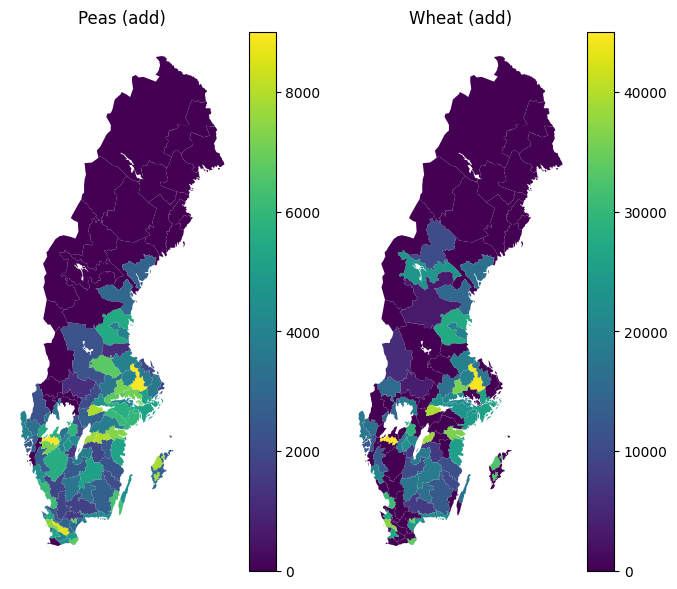

In [17]:
plot_crop_x0_x_chloropleths(f"figures/{scn}/added-crops-distribution-1.png")

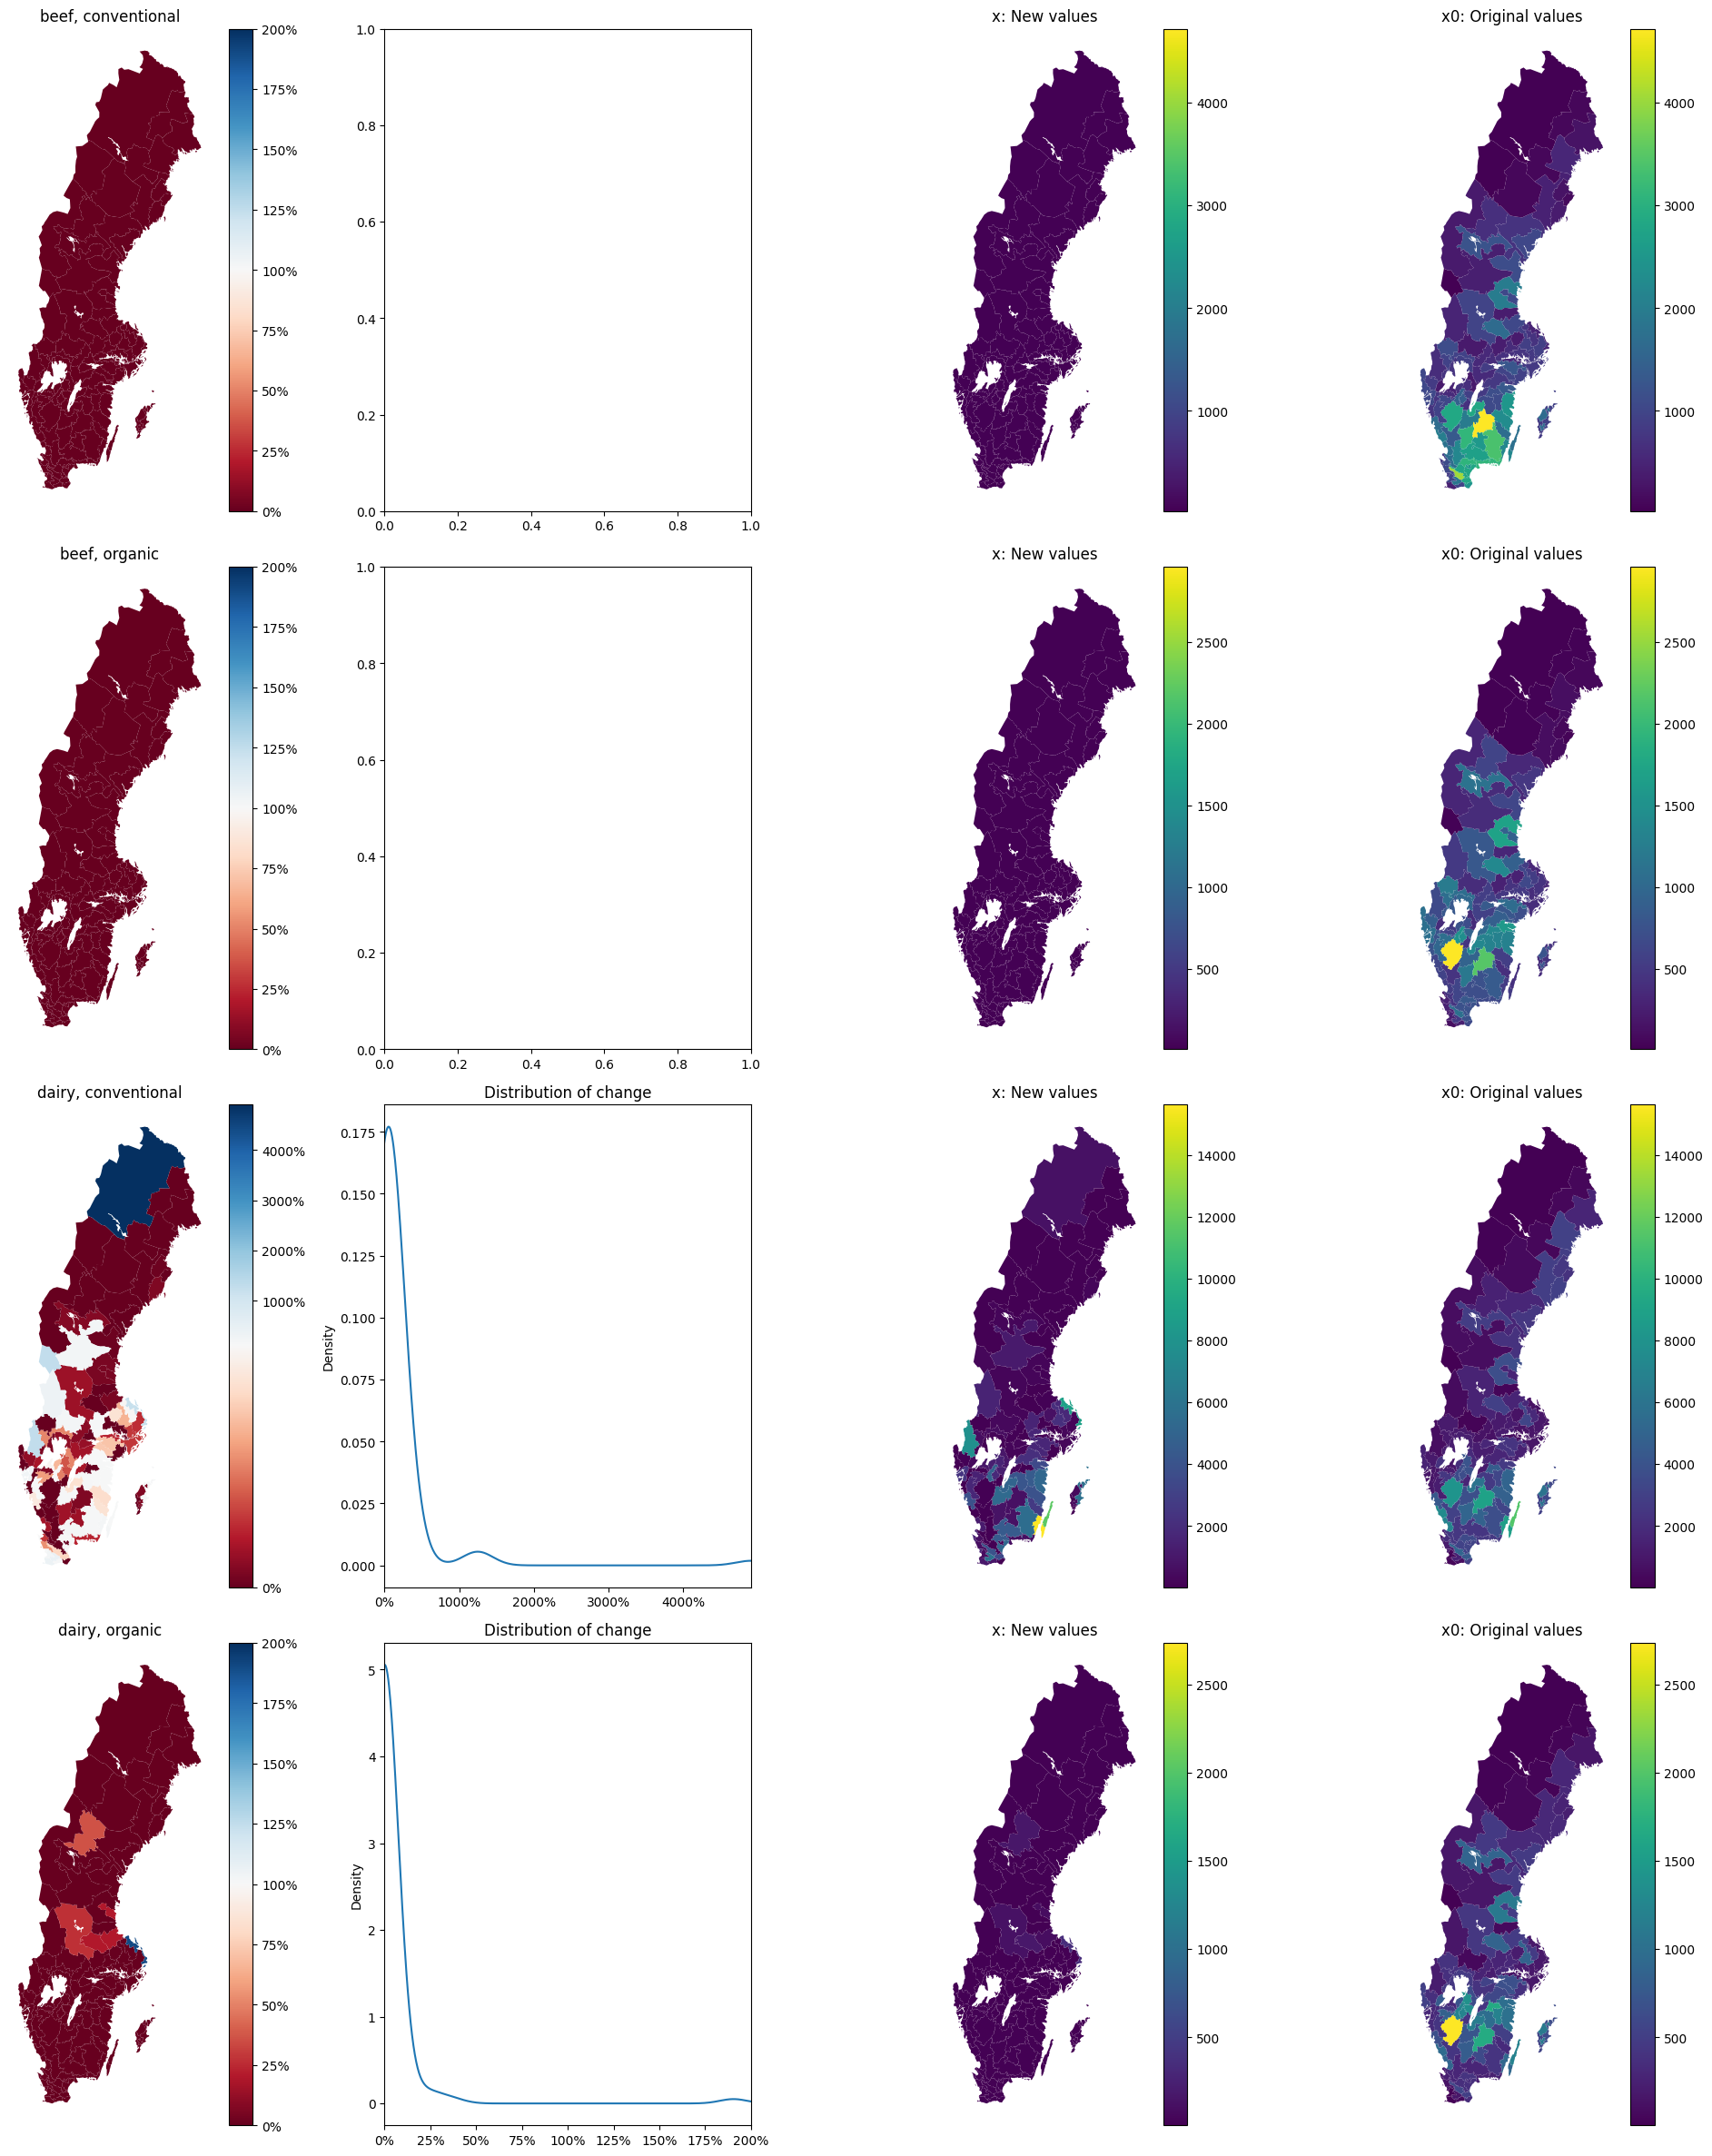

In [18]:
plot_cattle_x0_x_chloropleths(f"figures/{scn}/cattle-x-x0-deviation-1.png")

# Re-run the model to redistribute land-use for minimal change

Now that we optimised for maximum protein, we re-run the model with the protein amount as a constraint, instead optimising for minimal difference from the contemporary configuration.

We thus:
- Extract the max protein value from the previous optimisation run
- Create a constraint that maps x to the protein amount and ensures it is close to the max value
- Reapply the original optimisation goal

In [19]:
print(f"Max protein calculated as:\n{self.problem.value:e}")

Max protein calculated as:
7.097173e+08


In [20]:
max_protein_amount = self.problem.value

In [21]:
def protein_map_as_cons(factor=0.9):
    if max_protein_amount is None:
        raise Exception("Could not get the optimal value from the problem")

    b = max_protein_amount * factor

    return {
        "left": lambda x, M, b: M @ x - b,
        "right": lambda M, b: 0,
        "rel": ">=",
        "pars": { "M": prot_mask, "b": b }
    }

self.constraints["CX: Protein"] = protein_map_as_cons(0.975)

In [22]:
# Overwrite old problem with standard optimization objective,
# but with the protein constraint added
self.problem = self.get_cvx_problem()

In [23]:
self.solve(
    apply_solution=False,
    verbose=True,
    solver_settings=[{
        "solver": "GUROBI",
        "reoptimize": True,
        "verbose": True,
    }]
)

[17:41:06][FeedDistributor.solve] Finding solution with 'GUROBI' ... ===============================================================================
                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Jan 12 05:41:06 PM: Your problem has 388209 variables, 1910811 constraints, and 0 parameters.
(CVXPY) Jan 12 05:41:06 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 12 05:41:06 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 12 05:41:06 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 12 05:41:06 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                            

added_peas crop        region
Peas (add)  1011      4299.123078
            111       4930.579585
            1111      5032.552697
            1112      3393.214507
            112       4407.713852
                         ...     
            821       5099.179271
            831       2724.763502
            911       3216.965228
            912       7072.624707
            913       2779.126149
Length: 106, dtype: float64
added_wheat crop         region
Wheat (add)  1011      2.039163e+04
             111       2.294878e+04
             1111      2.374910e+04
             1112      2.776801e-11
             112       8.418933e+03
                           ...     
             821       1.669815e+04
             831       1.172260e+04
             911       4.219554e+03
             912       1.266583e+04
             913       4.763939e+03
Length: 106, dtype: float64


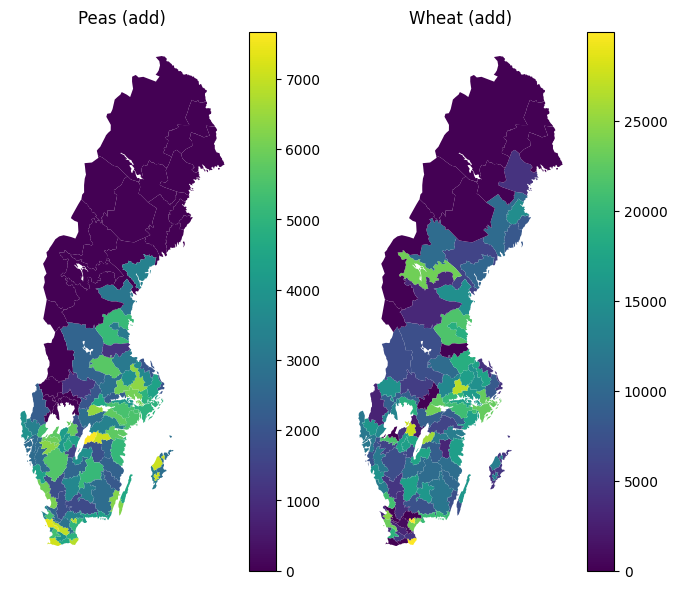

In [24]:
plot_crop_x0_x_chloropleths(f"figures/{scn}/added-crops-distribution-2.png")

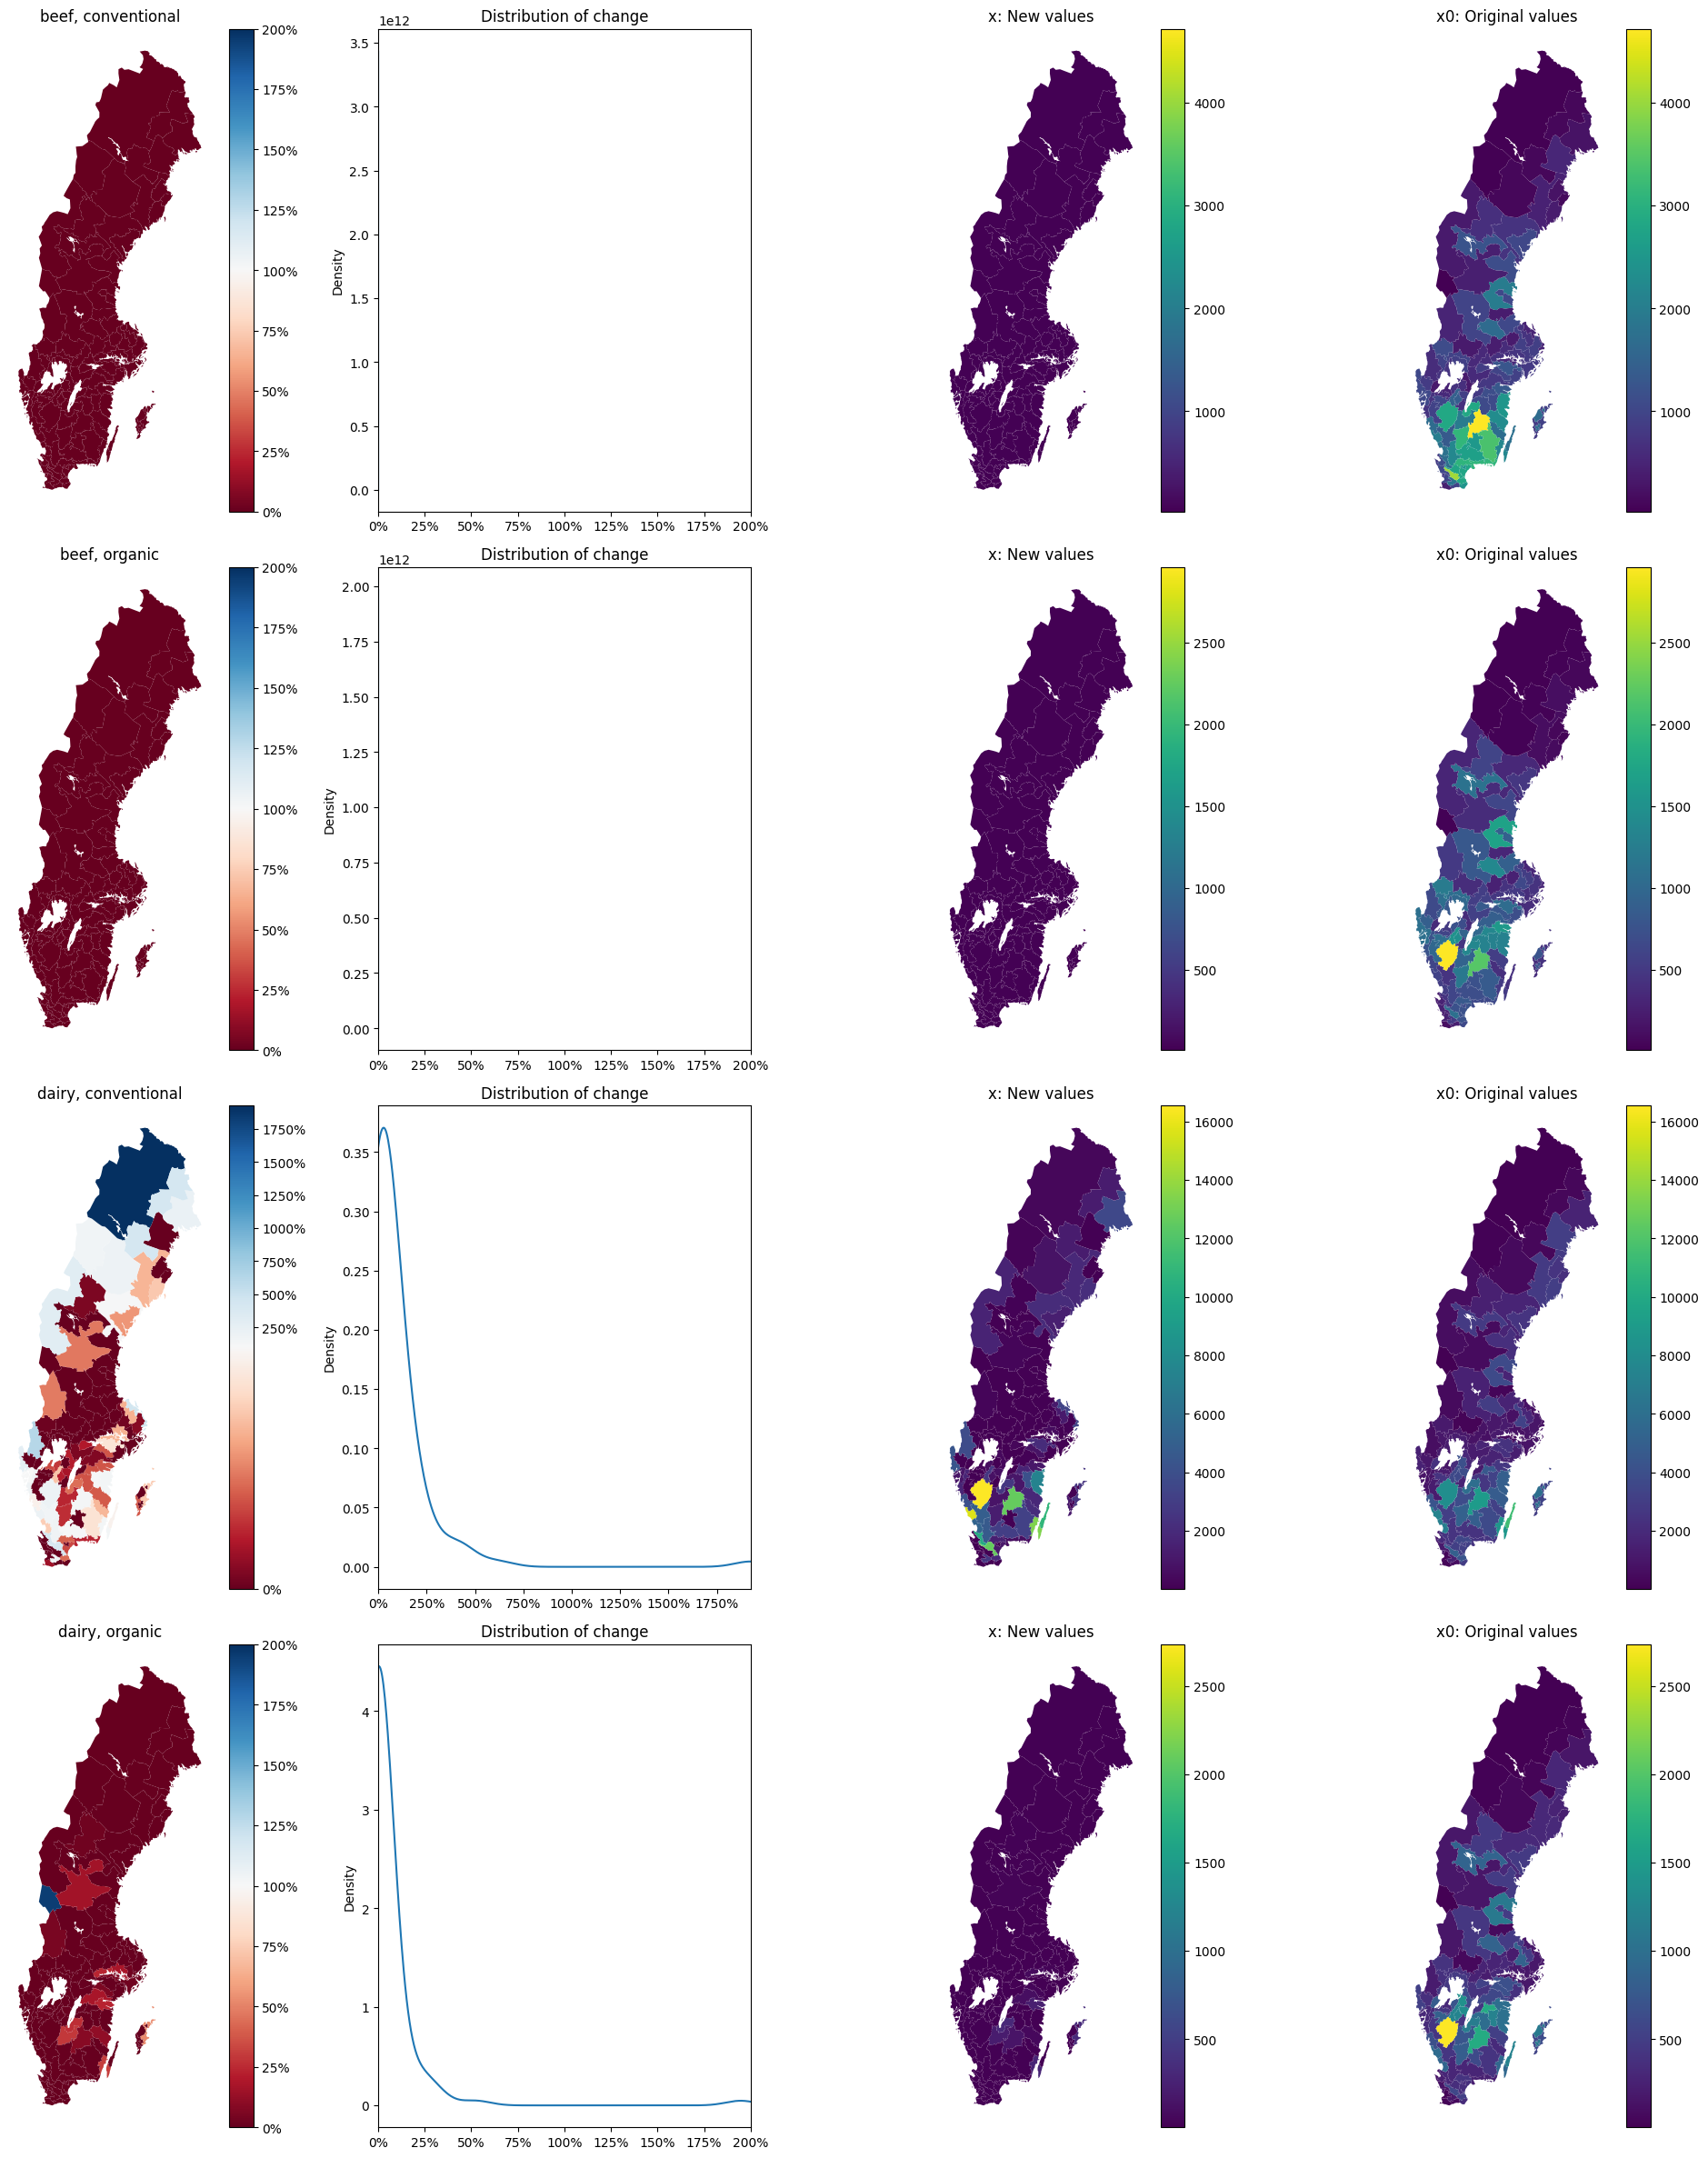

In [25]:
plot_cattle_x0_x_chloropleths(f"figures/{scn}/cattle-x-x0-deviation-2.png")

In [26]:
self.apply_solution()

# Calculate feed s
feed_mgmt.calculate()
# Calculate byprod
byprod_mgmt.calculate()
# Calculate manure
manure_mgmt.calculate()
# Calculate harvest of crop residues
crop_residue_mgmt.calculate()
# Calculate treatment of wastes and other feedstocks
waste.calculate()
# Calculate plant nutrient management
plant_nutrient_mgmt.calculate()
# Calculate energy requirements
machinery_and_energy_mgmt.calculate()
# Calculate inputs supply chain emissions
inputs.calculate()

/root/cibus/scenarios/../cibusmod/CIBUSmod/mgmt_modules/feed_mgmt.py:172: UserWarning: FeedMgmt: Specified domestic shares for 'by_prod' will have no effect! 
For by-products, imports are handled in the ByProductMgmt module and for crop residues, imports are not allowed.
  warnings.warn(
/root/cibus/scenarios/../cibusmod/CIBUSmod/utils/retriever.py:364: UserWarning: NaNs returned! No value for 'feed_composition' found in 'FeedMgmt'.xlsx for some of the supplied filters (n=318): 
----------
f_species = poultry
f_breed = broiler
f_region = 1011
f_prod_system = conventional
f_animal = breeding hens
f_feed = rapeseed cake
f_feed_par = AME
----------
f_species = poultry
f_breed = broiler
f_region = 1011
f_prod_system = conventional
f_animal = breeding roosters
f_feed = rapeseed cake
f_feed_par = AME
----------
f_species = poultry
f_breed = broiler
f_region = 1011
f_prod_system = conventional
f_animal = broilers
f_feed = rapeseed cake
f_feed_par = AME
----------
f_species = poultry
f_breed =

NOT IMPLEMENTED! NOT IMPLEMENTED! 

/root/cibus/scenarios/../cibusmod/CIBUSmod/mgmt_modules/plant_nutrient_mgmt.py:685: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  {warn_df.rename(f"Deficits (kg {element})").to_frame().applymap(lambda x: f"{x:,.0f}")}
/root/cibus/scenarios/../cibusmod/CIBUSmod/mgmt_modules/plant_nutrient_mgmt.py:679: UserWarning: 
Fertiliser N application did not cover requirements.
Likely due to total 'mineral_N_fertiliser_share' < 100% and not enough manure
and other organic fertiliser.
Total deficit: 590 tonnes N
----------------------------------------
                   Deficits (kg N)
region prod_system                
1112   organic               1,914
112    organic               2,231
1211   organic                  59
1212   organic                  17
1213   organic                  26
1215   organic                 150
1222   organic                 121
1615   organic                   4
1617   organic               7,692
1621   organic                 

In [27]:
from CIBUSmod.utils.misc import multiply_aligned

def calculate_bedding_material_use(self):
    '''Calculate use of bedding materials'''

    # Clear ParameterRetriever filters
    self.par.clear()
    self.feed_mgmt.par.clear()

    # Get types of bedding materials used
    fes = self.par.get_unique('feed', qry='parameter == "bedding_material_use"')

    for herd in self.herds:

        # Set species and breed filters
        self.par.set(
            species = herd.species,
            breed = herd.breed,
            sub_system = herd.sub_system
        )

        # Create dataframe
        df = pd.DataFrame(
            index = herd.index,
            columns = pd.MultiIndex.from_tuples(
                [tuple(list(i) + [fe]) for i in herd.data_attr.get('manure.mms_shares').columns for fe in fes],
                names = herd.data_attr.get('manure.mms_shares').columns.names + ['feed']
            )
        )

        # Calculate bedding material use [kg DM/year]
        DM = multiply_aligned(
            multiply_aligned(
                self.par.get_from_frame('bedding_material_use', df),
                herd.data_attr.get('manure.mms_shares')/100
            ) * 365.25,
            herd.data_attr.get('heads')
        )
        # Set bedding material use during grazing to zero
        if "grazing" in DM.columns.get_level_values("MMS"):
            DM.loc[:, (slice(None), slice(None), ["grazing"], slice(None))] *= 0

        def get_par(par: str):
            return (
                DM.mul(
                    self.feed_mgmt.par.get_from_frame(
                        "feed_composition", df, feed_par=par
                    )
                    / 100
                )
                .T.groupby(["prod_system", "animal", "MMS"])
                .sum()
                .T
            )

        # Calculate nitrogen,phosphorous and potassium in bedding materials
        N = get_par("N")  # [kg N/year]
        P = get_par("P")  # [kg P/year]
        K = get_par("K")  # [kg K/year]

        # Add data attributes
        for df, element in zip([DM,N,P,K], ['DM','N','P','K']):
            herd.data_attr.add(
                df,
                name = f'bedding_material{"_"+element if not element=="DM" else ""}',
                unit = f'kg {element}/year',
                orig = 'ManureMgmt',
                desc = 'Bedding material use' + ((' in terms of ' + element) if not element=='DM' else '')
            )

calculate_bedding_material_use(manure_mgmt)

# Store results

In [28]:
if False:
    new_value = (prot_mask @ self.problem.variables()[0]).value[0]
    protein_value = pd.Series(
        [max_protein_amount, new_value, new_value / max_protein_amount],
        index=["max", "reoptimised", "ratio"]
    )
    self.data_attr.add(
        protein_value.to_frame(),
        name="protein_value", 
        unit="1e3 * protein",
        orig="FeedDistributor",
        desc="Protein amounts optimised for",
    )

In [29]:
session.store(
    scn, 2020,
    demand, regions, crops, herds, waste, optproblem
)

Writing outputs to '/root/cibus/scenarios/data/output/main-nb.sqlite'


/root/cibus/scenarios/../cibusmod/CIBUSmod/utils/session_db.py:1533: UserWarning: NaNs in CropProduction.energy_use_supply_chain_emissions.
  warnings.warn(f'NaNs in {module.par.name}.{attr}.')
/root/cibus/scenarios/../cibusmod/CIBUSmod/utils/session_db.py:1535: UserWarning: Negative values of down to -236175203.85981813 */year in AnimalHerd.feed_req_min.
  warnings.warn(f'Negative values of down to {data.min().min()} {module.data_attr[attr]["unit"]} in {module_name}.{attr}.')


Outputs stored!


In [30]:
plant_nutrient_mgmt

In [31]:
session

,calculated
year,
2020,Not calculated
,calculated
year,
2020,2025-01-12 17:49:10
,calculated
year,
2020,Not calculated
,calculated
year,


In [37]:
"""
Creates C7: Drops variables

Constrain crops to certain regions based on minimum growing degree days (GDD5).
The minimum GDD5 for different crops is set with the parameter 'min_GDD5' in the
'CropProduction' module. The number of GDD5 in each region is defined by the
parameter 'GDD' in the 'Regions' module.

This constraint also indirectly constrains animals with regional demand for
crops that can't be grown in a region.
"""

# This constraint is not implemented as a constraint in the solver but instead
# drops variables representing crops or animals that can't be present in a
# region.

# IMPORTANT: This must be run after all other constraints have been defined!

ani_idx = self.x_idx["ani"]
crp_idx = self.x_idx["crp"]
fds_idx = self.x_idx["fds"]

# Get allowed crop-region combinations (i.e. region GDD5 >= min_GDD5 for crop)
self.crops.par.clear()
self.regions.par.clear()
sel_crp = crp_idx[
    self.regions.par.get("GDD5", **crp_idx.to_frame().to_dict("list"))
    >= self.crops.par.get("min_GDD5", **crp_idx.to_frame().to_dict("list"))
]

self.feed_mgmt.par.clear()
self.feed_mgmt.par.clear()


# Get positions of variables to keep
#n_ani = len(ani_idx)
#n_crp = len(crp_idx)
#isel_ani = list(range(0, n_ani))
#isel_crp = [crp_idx.get_loc(s) + n_ani for s in sel_crp]
#isel_fds = list(range(n_ani + n_crp, n_ani + n_crp + len(fds_idx)))
#isel = isel_ani + isel_crp + isel_fds

# Store short index (i.e. index of variables after dropping)
#self.x_idx_short = {"ani": ani_idx, "crp": sel_crp, "fds": fds_idx}

# Drop variables from objective and constraint matrices
#for mat in self.matrices().values():
#    if mat.M.shape[1] > len(isel):
#        mat.M = mat.M[:, isel]
#        mat.cols["ani"] = ani_idx.copy()
#        mat.cols["crp"] = sel_crp.copy()
#        mat.cols["fds"] = fds_idx.copy()



MultiIndex([(       'Apples', 'conventional', '1011'),
            (       'Apples', 'conventional',  '111'),
            (       'Apples', 'conventional', '1111'),
            (       'Apples', 'conventional', '1112'),
            (       'Apples', 'conventional',  '112'),
            (       'Apples', 'conventional', '1121'),
            (       'Apples', 'conventional', '1122'),
            (       'Apples', 'conventional', '1123'),
            (       'Apples', 'conventional', '1124'),
            (       'Apples', 'conventional', '1131'),
            ...
            ('Wheat, winter',      'organic',  '731'),
            ('Wheat, winter',      'organic',  '811'),
            ('Wheat, winter',      'organic',  '812'),
            ('Wheat, winter',      'organic',  '813'),
            ('Wheat, winter',      'organic',  '814'),
            ('Wheat, winter',      'organic',  '821'),
            ('Wheat, winter',      'organic',  '831'),
            ('Wheat, winter',      'organic',  '9

In [ ]:
"""
Creates C7: Drops variables

Constrain crops to certain regions based on minimum growing degree days (GDD5).
The minimum GDD5 for different crops is set with the parameter 'min_GDD5' in the
'CropProduction' module. The number of GDD5 in each region is defined by the
parameter 'GDD' in the 'Regions' module.

This constraint also indirectly constrains animals with regional demand for
crops that can't be grown in a region.
"""

# This constraint is not implemented as a constraint in the solver but instead
# drops variables representing crops or animals that can't be present in a
# region.

# IMPORTANT: This must be run after all other constraints have been defined!

ani_idx = self.x_idx["ani"]
crp_idx = self.x_idx["crp"]
fds_idx = self.x_idx["fds"]

# Get allowed crop-region combinations (i.e. region GDD5 >= min_GDD5 for crop)
self.crops.par.clear()
self.regions.par.clear()
sel_crp = crp_idx[
    self.regions.par.get("GDD5", **crp_idx.to_frame().to_dict("list"))
    >= self.crops.par.get("min_GDD5", **crp_idx.to_frame().to_dict("list"))
]

# Get positions of variables to keep for
n_ani = len(ani_idx)
n_crp = len(crp_idx)
isel_ani = list(range(0, n_ani))
isel_crp = [crp_idx.get_loc(s) + n_ani for s in sel_crp]
isel_fds = list(range(n_ani + n_crp, n_ani + n_crp + len(fds_idx)))
isel = isel_ani + isel_crp + isel_fds

isel
